<h1><center>03-vector-search assignment</center></h1>

#### Architecture - Semantic Search using Elastic Search


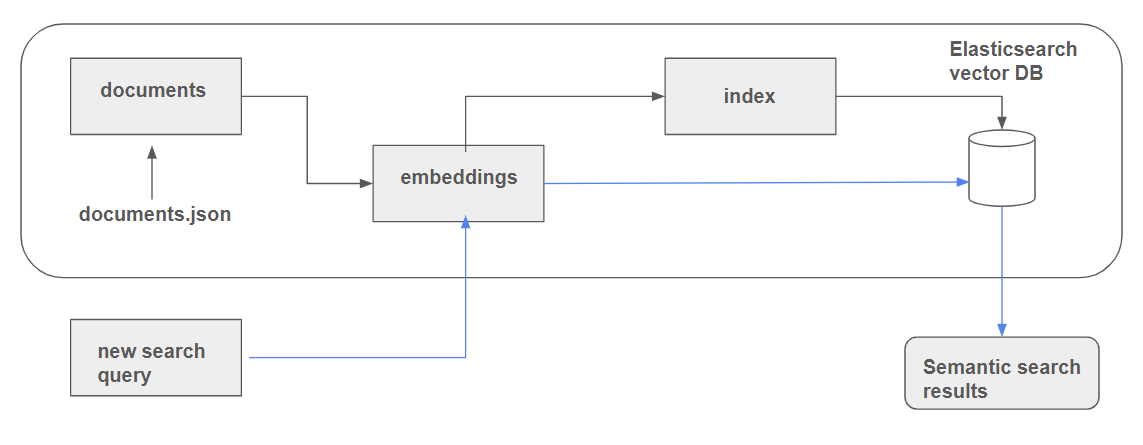

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

<!-- #### Step 1: Prepare documents -->

In [15]:
# import json

# with open('documents.json', 'rt') as f_in:
#     docs_raw = json.load(f_in)

In [16]:
# documents = []

# for course_dict in docs_raw:
#     for doc in course_dict['documents']:
#         doc['course'] = course_dict['course']
#         documents.append(doc)

# documents[1]

#### Step Q1. Getting the embeddings model

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [3]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
# model = SentenceTransformer("all-mpnet-base-v2")
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

/Users/manaschaity/Documents/python_venvs/venv_llmzc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [7]:
# len(model.encode("This is a simple sentence"))
user_question = "I just discovered the course. Can I still join it?"
embedding_ex = model.encode(user_question)

In [18]:
print(f"Answer: {round(embedding_ex[:1][0],3)}")

Answer: 0.07800000160932541


#### Prepare the documents

In [24]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()
len(documents)

948

In [25]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [32]:
# We will use only a subset of the questions - the questions for "machine-learning-zoomcamp". 
# After filtering, you should have only 375 documents
filtered_docs = filter(lambda x: x['course'] == 'machine-learning-zoomcamp', documents)

filtered_docs = list(filtered_docs)
print(len(filtered_docs))

375


#### Q2. Creating the embeddings
Now for each document, we will create an embedding for both question and answer fields.

We want to put all of them into a single matrix X:

- Create a list embeddings
- Iterate over each document
- qa_text = f'{question} {text}'
- compute the embedding for qa_text, append to embeddings
- At the end, let X = np.array(embeddings) (import numpy as np)

What's the shape of X? (X.shape). Include the parantheses.

In [36]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [35]:
doc = documents[0]
qa_text = f'{doc['question']} {doc['text']}'
print(qa_text)

Course - When will the course start? The purpose of this document is to capture frequently asked technical questions
The exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1
Subscribe to course public Google Calendar (it works from Desktop only).
Register before the course starts using this link.
Join the course Telegram channel with announcements.
Don’t forget to register in DataTalks.Club's Slack and join the channel.


In [39]:
#created the dense vector using the pre-trained model
# operations = []
# for doc in documents:
#     # Transforming the title into an embedding using the model
#     doc["text_vector"] = model.encode(doc["text"]).tolist()
#     operations.append(doc)

import numpy as np
from tqdm import tqdm

embeddings = []
for doc in tqdm(filtered_docs):
    qa_text = f'{doc['question']} {doc['text']}'
    # Transforming the title into an embedding using the model
    embedding_qa_text = model.encode(qa_text).tolist()
    embeddings.append(embedding_qa_text)

X = np.array(embeddings)
print(f"Shape of X: {X.shape}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:06<00:00, 58.80it/s]

Shape of X: (375, 768)


In [72]:
len(embeddings)

375

#### Q3. Search

We have the embeddings and the query vector. Now let's compute the cosine similarity between the vector from Q1 (let's call it v) and the matrix from Q2.

The vectors returned from the embedding model are already normalized (you can check it by computing a dot product of a vector with itself - it should return something very close to 1.0). This means that in order to compute the coside similarity, it's sufficient to multiply the matrix X by the vector v:

```scores = X.dot(v)```

In [42]:
user_question = "I just discovered the course. Can I still join it?"
v = model.encode(user_question)
v.shape

(768,)

In [43]:
scores = X.dot(v)

In [48]:
scores[:17]

array([0.28921745, 0.43505096, 0.22057271, 0.12808593, 0.32875459,
       0.45899988, 0.44893111, 0.27017071, 0.21397506, 0.3397457 ,
       0.16333919, 0.31591803, 0.01536206, 0.41424065, 0.65065732,
       0.41278664, 0.20239046])

In [46]:
max_score = max(scores)
max_element_index = list(scores).index(max_score)
max_element_index

14

In [49]:
scores[14]

0.6506573213072671

In [50]:
filtered_docs[14]

{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
 'section': 'General course-related questions',
 'question': 'The course has already started. Can I still join it?',
 'course': 'machine-learning-zoomcamp',
 'id': 'ee58a693'}

#### Vector search

In [54]:
class VectorSearchEngine():
    def __init__(self, documents, embeddings):
        self.documents = documents
        self.embeddings = embeddings

    def search(self, v_query, num_results=10):
        scores = self.embeddings.dot(v_query)
        idx = np.argsort(-scores)[:num_results]
        return [self.documents[i] for i in idx]

search_engine = VectorSearchEngine(documents=filtered_docs, embeddings=X)
search_engine.search(v, num_results=5)

[{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'section': 'General course-related questions',
  'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'id': 'ee58a693'},
 {'text': 'Welcome to the course! Go to the course page (http://mlzoomcamp.com/), scroll down and start going through the course materials. Then read everything in the cohort folder for your cohort’s year.\nClick on the links and start watching the videos. Also watch office hours from previous cohorts. Go to DTC youtube channel and click on Playlists and search for {course yyyy}. ML Zoomcamp was first launched in 2021.\nOr you c

#### Q4. Hit-rate for our search engine

In [55]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [59]:
ground_truth[:6]

[{'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Can you provide a link to sign up?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Is there an FAQ for this Machine Learning course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Does this course have a GitHub repository for the sign-up link?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'How can I structure my questions and answers for the course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Are the course videos live or pre-recorded?',
  'course': 'machine-learning-zoomcamp',
  'document': '39fda9f0'}]

In [56]:
len(ground_truth)

1830

In [62]:
search_engine = VectorSearchEngine(documents=filtered_docs, embeddings=X)
# search_engine.search(v, num_results=5)

relevance_total = []

for q in tqdm(ground_truth):
    doc_id = q['document']

    v = model.encode(q['question'])
    # results = elastic_search(query=q['question'], course=q['course'])
    results = search_engine.search(v, num_results=5)
    relevance = [d['id'] == doc_id for d in results]
    relevance_total.append(relevance)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:48<00:00, 38.08it/s]


In [63]:
len(relevance_total)

1830

In [64]:
relevance_total[:5]

[[False, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, True, False]]

In [65]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

In [66]:
hit_rate(relevance_total)

0.9398907103825137

#### Q5. Indexing with Elasticsearch

In [67]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '6a05a85ee7e1', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'Hb1gKnXpSrS_2IVhkuUdvA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [68]:
len(v)

768

In [74]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [90]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "id": {"type": "text"},
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [91]:
index_name = "hw3-index"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'hw3-index'})

#### Step 5: Add documents into index

In [92]:
operations = []
for doc in tqdm(filtered_docs):
    qa_text = f'{doc['question']} {doc['text']}'
    # Transforming the title into an embedding using the model
    embedding_qa_text = model.encode(qa_text).tolist()
    doc["text_vector"] = embedding_qa_text
    operations.append(doc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:04<00:00, 92.21it/s]


In [93]:
len(operations)

375

In [94]:
operations[0]

{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'section': 'General course-related questions',
 'question': 'How do I sign up?',
 'course': 'machine-learning-zoomcamp',
 'id': '0227b872',
 'text_vector': [0.08805913478136063,
  0.015593641437590122,
  0.07925575226545334,
  0.025275785475969315,
  0.07557642459869385,
  -0.03905966505408287,
  -0.04138130322098732,
  0.025291703641414642,
  0.024324173107743263,
  0.003625940764322877,
  -0.007282888051122427,
  -0.03287505730986595,
  0.06129566952586174,
  -0.057110078632831573,
  0.011677452363073826,
  -0.017944157123565674,
  0.04492057114839554,
  -0.05416066572070122

In [95]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Q5. Indexing with Elasticsearch

In [96]:
user_question = "I just discovered the course. Can I still join it?"
v = model.encode(user_question)
v.shape

(768,)

In [97]:
query = {
    "field": "text_vector",
    "query_vector": model.encode(user_question),
    "k": 5,
    "num_candidates": 10000, 
}

res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course", "id"])
res["hits"]["hits"]

In [101]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course", "id"])
results = res["hits"]["hits"]

In [104]:
results[0]["_source"]["id"]

'ee58a693'

#### Q6. Hit-rate for Elasticsearch

In [100]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [106]:
relevance_total_es = []

for q in tqdm(ground_truth):
    doc_id = q['document']

    v = model.encode(q['question'])
    # results = elastic_search(query=q['question'], course=q['course'])
    # results = search_engine.search(v, num_results=5)
    query = {
        "field": "text_vector",
        "query_vector": v,
        "k": 5,
        "num_candidates": 10000, 
    }

    res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course", "id"])
    results = res["hits"]["hits"]
    
    relevance = [d["_source"]["id"] == doc_id for d in results]
    relevance_total_es.append(relevance)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:36<00:00, 50.60it/s]


In [107]:
relevance_total_es[:7]

[[False, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, True, False],
 [True, False, False, False, False],
 [True, False, False, False, False]]

In [108]:
hit_rate(relevance_total_es)

0.9398907103825137

In [109]:
### search using ES capablities 

In [142]:
index_name

'hw3-index'

In [113]:
def elastic_search(query, course):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": course
                    }
                }
            }
        }
    }

    response = es_client.search(index=index_name, body=search_query)
    
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])
    
    return result_docs

In [115]:
user_question = "I just discovered the course. Can I still join it?"
es_result = elastic_search(
    query=user_question,
    course="machine-learning-zoomcamp"
)

In [116]:
len(es_result)

5

In [121]:
es_result[0]

{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
 'section': 'General course-related questions',
 'question': 'The course has already started. Can I still join it?',
 'course': 'machine-learning-zoomcamp',
 'id': 'ee58a693',
 'text_vector': [0.08062857389450073,
  -0.06663881242275238,
  0.025273088365793228,
  -0.013004409149289131,
  0.07587283849716187,
  -0.05946262925863266,
  -0.021883899345993996,
  0.002900051651522517,
  0.0007929456769488752,
  -0.005222362000495195,
  -0.03365178033709526,
  -0.027913536876440048,
  0.05811658129096031,
  0.039748262614011765,
  0.05441853404045105,
  -0.038251642137765884,
  0.06305743008852005,
  -0.038969889

In [119]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [143]:
relevance_total_es = []

for q in tqdm(ground_truth):
    doc_id = q['document']
    user_question = q['question']
    es_result = elastic_search(
        query=user_question,
        course="machine-learning-zoomcamp"
    )
    
    relevance = [d["id"] == doc_id for d in es_result]
    relevance_total_es.append(relevance)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:17<00:00, 102.12it/s]


In [133]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [130]:
query = {
        "field": "text_vector",
        "query_vector": ground_truth[0]['question'],
        "k": 5,
        "num_candidates": 10000, 
    }

In [131]:
es_result = elastic_search(
    query=user_question,
    course="machine-learning-zoomcamp"
)

In [134]:
for r in es_result:
    print(r['id'])

ee58a693
0a278fb2
c25b3de4
9f261648
41521c92


In [144]:
relevance_total_es[:6]

[[True, False, False, False, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [False, True, False, False, False],
 [False, False, False, False, False],
 [False, True, False, False, False]]

In [145]:
hit_rate(relevance_total_es)

0.7530054644808744

In [88]:
#### Step 6: Create end user query

In [17]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [18]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [ ]:
# class VectorSearchEngine():
#     def __init__(self, documents, embeddings):
#         self.documents = documents
#         self.embeddings = embeddings

#     def search(self, v_query, num_results=10):
#         scores = self.embeddings.dot(v_query)
#         idx = np.argsort(-scores)[:num_results]
#         return [self.documents[i] for i in idx]

# search_engine = VectorSearchEngine(documents=filtered_docs, embeddings=X)
# search_engine.search(v, num_results=5)

class VectorSearchEngineUsingES():
    def __init__(self, documents, embeddings):
        self.documents = documents
        self.embeddings = embeddings

    def search(self, v_query, num_results=10):
        scores = self.embeddings.dot(v_query)
        idx = np.argsort(-scores)[:num_results]
        return [self.documents[i] for i in idx]

search_engine = VectorSearchEngine(documents=filtered_docs, embeddings=X)
search_engine.search(v, num_results=5)


In [19]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
results = res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': '-BY3YZABY4SUV-QiWtCV',
  '_score': 0.7147919,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'CxY4YZABY4SUV-QiNdSb',
  '_score': 0.6134734,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares at

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [ ]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [ ]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

In [ ]:
response["hits"]["hits"]

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch